<h2><center><font color="black"><strong>Model for flats in Lyon</strong></font></center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
    # Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

    # Pipeline & Preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

    # Scores
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.metrics import mean_absolute_percentage_error

#### Import of dataset

In [3]:
#df_Paris = pd.read_csv('../Data/update_data/df_Paris_Processed_Louise.csv', low_memory = False, encoding = 'latin1')
df = pd.read_csv('../Data/df_Lyon_appartement_vf.csv', low_memory = False, encoding = 'latin1')

In [48]:
dummies_pr_var_continues(df, 'dist_metro', 300)
dummies_pr_var_continues(df, 'Nombre_dependance', 0)
dummies_pr_var_continues(df, 'Ec_maternelle', 0)
dummies_pr_var_continues(df, 'Ec_elementaire', 0)
dummies_pr_var_continues(df, 'nombre_pieces_principales', 3)

**Run helpers**

In [6]:
%run '../Helpers/Data_Process.py'

In [7]:
%run '../Helpers/Models.py'

In [8]:
%run '../Helpers/Data_visualisation.py'

#### Visualisation of the dataset

In [10]:
df.tail(4)

,id_mutation,date_mutation,code_type_local,code_commune,surface_terrain,surface_reelle_bati,nombre_pieces_principales,nature_culture,valeur_fonciere,latitude,longitude,nombre_lots,numero_disposition,code_departement,Nombre_unite,Nombre_dependance,Year,num_trimestre,quarter,geometry,index_right,epci_name,iris_code,iris_name,iris_name_l,Prix_m2,Month,Pris_m2_moy_iris,std,Vente_par_iris,Vente_par_iris_tri,N_logements,N_res_ppale,N_res_second,N_vacant,N_maisons,N_apparts,N_proprietaire,N_locataire,DISP_MED19,Ec_maternelle,Ec_elementaire,P19_LOG,P19_RP_SDB,P19_RP_CCCOLL,P19_RP_CCIND,P19_RP_CINDELEC,UU2020,COM,TRIRIS,GRD_QUART,TYP_IRIS,P19_POP1564,P19_POP1524,P19_POP2554,P19_POP5564,P19_ACT1564,P19_CHOM1564,P19_INACT1564,Part_dactifs,Part_chomeurs,Arrondissement,dist_metro
25345,2019-996348,2019-04-08,2.0,69389,0.0,82.0,5.0,0,163000.0,45.788604,4.789805,2,1,69,1,1,2019,2,2019_Q2,POINT (4.789805 45.788604),43426,['MÃÂ©tropole de Lyon'],693890604,La Sauvegard,la sauvegarde,1987.804878,4,2072.357724,294.610859,4,1,1099.0,979.0,13.0,107.0,4.0,1091.0,89.0,885.0,14040,0,1,1130.499476,970.658852,926.366175,54.480428,20.572448,760,69389,691171,6938906,H,1468.46922,322.548936,940.251626,205.668658,864.944919,182.596732,603.524301,0.589011,0.124345,69389,1484.614285
25346,2022-320788,2022-01-12,2.0,69389,0.0,83.0,4.0,0,292985.0,45.787037,4.789816,1,1,69,1,1,2022,1,2022_Q1,POINT (4.789816 45.787037),43426,['MÃÂ©tropole de Lyon'],693890604,La Sauvegard,la sauvegarde,3529.939759,1,3184.539815,917.365047,4,3,1099.0,979.0,13.0,107.0,4.0,1091.0,89.0,885.0,14040,0,1,1130.499476,970.658852,926.366175,54.480428,20.572448,760,69389,691171,6938906,H,1468.46922,322.548936,940.251626,205.668658,864.944919,182.596732,603.524301,0.589011,0.124345,69389,1375.022095
25347,2022-321183,2022-02-10,2.0,69389,0.0,68.0,4.0,0,165000.0,45.788604,4.789805,2,1,69,1,2,2022,1,2022_Q1,POINT (4.789805 45.788604),43426,['MÃÂ©tropole de Lyon'],693890604,La Sauvegard,la sauvegarde,2426.470588,2,3184.539815,917.365047,4,3,1099.0,979.0,13.0,107.0,4.0,1091.0,89.0,885.0,14040,0,1,1130.499476,970.658852,926.366175,54.480428,20.572448,760,69389,691171,6938906,H,1468.46922,322.548936,940.251626,205.668658,864.944919,182.596732,603.524301,0.589011,0.124345,69389,1484.614285
25348,2022-321857,2022-03-21,2.0,69389,0.0,64.0,3.0,0,216210.0,45.787037,4.789816,1,1,69,1,1,2022,1,2022_Q1,POINT (4.789816 45.787037),43426,['MÃÂ©tropole de Lyon'],693890604,La Sauvegard,la sauvegarde,3378.281250,3,3184.539815,917.365047,4,3,1099.0,979.0,13.0,107.0,4.0,1091.0,89.0,885.0,14040,0,1,1130.499476,970.658852,926.366175,54.480428,20.572448,760,69389,691171,6938906,H,1468.46922,322.548936,940.251626,205.668658,864.944919,182.596732,603.524301,0.589011,0.124345,69389,1375.022095


## Split temporel : 

In [57]:
df_train = df[df['date_mutation'] < '2021-04-01']
df_test = df[df['date_mutation'] >= '2021-04-01']

In [58]:
df_test.shape[0] / (df_train.shape[0] + df_test.shape[0])

0.2433232080160953

In [59]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['quarter']])], axis = 1)

#### We split apartments into 2 groups according to their districts

In [60]:
df_train['group_bien_standard'] = 'group1'
df_train.loc[df_train['Arrondissement'].isin([69383, 69387, 69388]), 'group_bien_standard'] = 'group2'

In [61]:
df_train.group_bien_standard.value_counts()

group2    10063
group1     9118
Name: group_bien_standard, dtype: int64

## Price index

In [62]:
df_train_1 = df_train[df_train['group_bien_standard'] == 'group1']
df_train_2 = df_train[df_train['group_bien_standard'] == 'group2']

In [63]:
df_train_1.shape[0], df_train_2.shape[0]

(9118, 10063)

In [64]:
def group(data, group, summary = False) :
    data['n_pieces_BienStandard'] = data['nombre_pieces_principales']-3
    if group == 'group1' :
        data['n_dependances_BienStandard'] = data['Nombre_dependance']
    if group == 'group2' : 
        data['n_dependances_BienStandard'] = data['Nombre_dependance'] - 1
    features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
    'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
    'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1',
    'quarter_2020_Q2', 'quarter_2020_Q3', 'quarter_2020_Q4',
    'quarter_2021_Q1',
    'n_pieces_BienStandard', 'n_dependances_BienStandard']
    outcome = 'Prix_m2'
    model_group = model_OLS_prix(data, 'Prix_m2', features_ols, summary)
    return(model_group)

In [65]:
# Pour le group1 : nombre_pieces_principales = 3
# Nombre_dependance = 0

In [66]:
model1 = group(df_train_1, 'group1', summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     97.06
Date:                Tue, 04 Apr 2023   Prob (F-statistic):          5.16e-296
Time:                        10:25:03   Log-Likelihood:                -77713.
No. Observations:                9118   AIC:                         1.555e+05
Df Residuals:                    9101   BIC:                         1.556e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [67]:
# Pour le group2 : nombre_pieces_principales = 3
# Nombre_dependance = 1

In [68]:
model2 = group(df_train_2, 'group2', summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     198.5
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:25:04   Log-Likelihood:                -81463.
No. Observations:               10063   AIC:                         1.630e+05
Df Residuals:                   10046   BIC:                         1.631e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

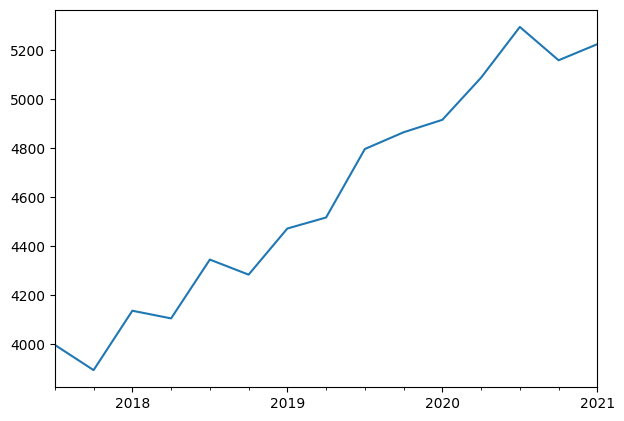

In [69]:
df_train_1 = add_indice_prix(df_train_1, indice_prix_quarter(model1, plot = True))

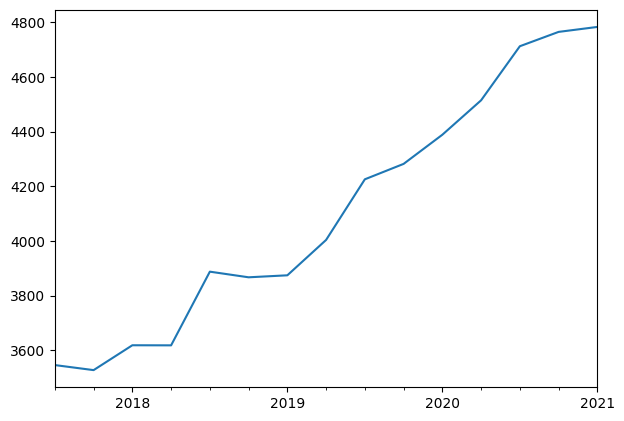

In [70]:
df_train_2 = add_indice_prix(df_train_2, indice_prix_quarter(model2, plot = True))

In [71]:
df_train = pd.concat([df_train_1, df_train_2], axis = 0)

## Visualisation

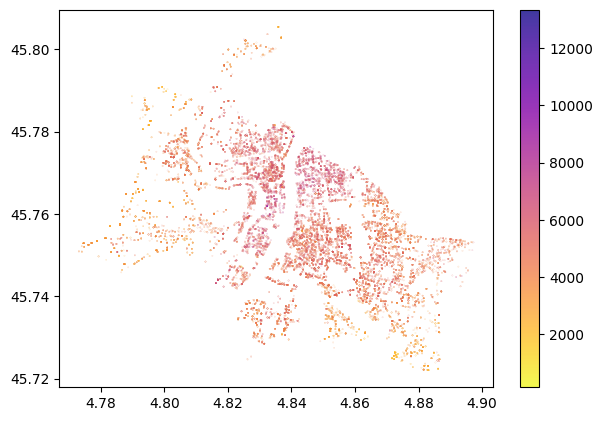

In [30]:
visualise(df, 'Prix_m2')

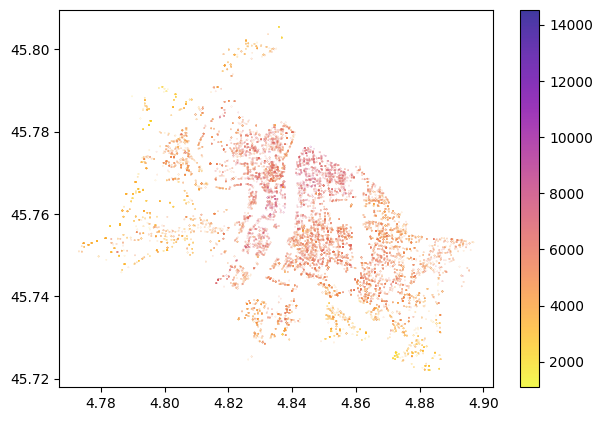

In [31]:
visualise(df_train, 'Prix_m2_actualise_Q1_2021')

## Selection of features : 

In [72]:
df_test_vif = df[['nombre_pieces_principales','Nombre_dependance',
                  'N_apparts', 'Part_chomeurs', 'Ec_maternelle', 'Ec_elementaire',
                  'dist_metro']]

In [73]:
calc_vif(df_test_vif)

,variables,VIF
0,nombre_pieces_principales,5.463163
1,Nombre_dependance,2.076658
2,N_apparts,6.264683
3,Part_chomeurs,9.026997
4,Ec_maternelle,2.090434
5,Ec_elementaire,3.103578
6,dist_metro,2.360489


## K nearest neighbours with coordinates

Les features sont : 
- pour le KNN : 
    - latitude; longitude
- pour le Random Forest ou GBoost:
    - à compléter

In [34]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train = 'Prix_m2_actualise_Q1_2021'
label_test = 'Prix_m2'

In [35]:
knn_pipe = model_KNN_coordinates(df_train, df_test, features_knn,
                          label_train, label_test,
                          MinMaxScaler(), 'uniform', 19, 5)

Returned hyperparameter: {'Knn__n_neighbors': 17}


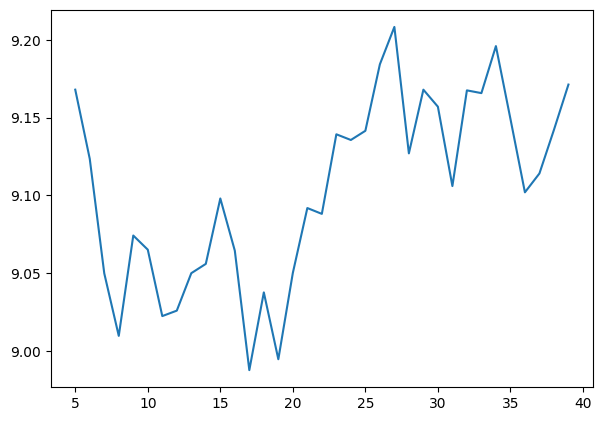

In [36]:
X_train_knn = df_train[features_knn]
X_test_knn = df_test[features_knn]
        # outcomes
y_train = df_train[label_train]
y_test = df_test[label_test]
knn = []
mdape = []
for i in np.arange(5, 40) :
    knn_model = KNeighborsRegressor(n_neighbors=i)
    knn_model.fit(X_train_knn, y_train)
    knn.append(i)
    mdape_i = MDAPE(knn_model.predict(df_test[features_knn]), df_test[label_test])
    mdape.append(mdape_i)
plt.plot(knn, mdape)
plt.show()

In [37]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe, df_train[features_knn], df_train[label_train])

MAPE:  10.999049785849897
MDAPE:  8.467092144167236


In [38]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test[features_knn], df_test[label_test])

MAPE:  12.827685242732187
MDAPE:  8.939276841699312


#### Analysis of MDAPE after Knn model

In [74]:
X_test = df_test.copy()
    # Add predictions to the test sample
y_pred = knn_pipe.predict(X_test[features_knn])
X_test["y_pred"] = y_pred
    # Add the true value of the outcome in the test sample
X_test['y_true'] = df_test[label_test]
    # Compute the relative percentage error
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100

In [75]:
X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T

Arrondissement,69381,69382,69383,69384,69385,69386,69387,69388,69389
mdape,9.964147,10.05901,7.392788,10.055922,10.401251,8.217082,8.471755,9.1403,10.167047


In [76]:
X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T

quarter,2021_Q2,2021_Q3,2021_Q4,2022_Q1,2022_Q2
mdape,8.582786,8.759749,9.165561,8.777509,9.532929


In [77]:
#round(X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T, 3).to_latex()

In [78]:
#round(X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T, 3).to_latex()

In [85]:
fig = px.scatter(X_test, x = 'valeur_fonciere', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 120])
fig.show()

In [87]:
fig = px.scatter(X_test, x = 'surface_reelle_bati', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 120])
fig.show()

In [88]:
fig = px.scatter(X_test, x = 'Prix_m2', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 120])
fig.show()

## Random Forest

In [90]:
%run '../Helpers/Models.py'

In [91]:
features_RF = ['nombre_pieces_principales','Nombre_dependance_dummy',
                  'N_apparts', 'Part_chomeurs', 'Ec_maternelle', 'Ec_elementaire',
                  'dist_metro']

In [92]:
RF_model = model_RF_post_KNN(df_test, df_train, features_RF, features_knn, label_train, label_test,
                      model_knn = knn_pipe, standardisation = StandardScaler(), range_depth = [50, 70, 80, 90], nb_cv = 5)

In [93]:
X_train_rf = df_train[features_RF]
X_train_rf['y_pred_knn'] = knn_pipe.predict(df_train[features_knn])
X_test_rf = df_test[features_RF]
X_test_rf['y_pred_knn'] = knn_pipe.predict(df_test[features_knn])
compute_scores(RF_model, X_test_rf, df_test[label_test])

MAPE:  12.899621759700427
MDAPE:  8.702822240537568


In [94]:
RF_model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('RForest', RandomForestRegressor(max_depth=50))])

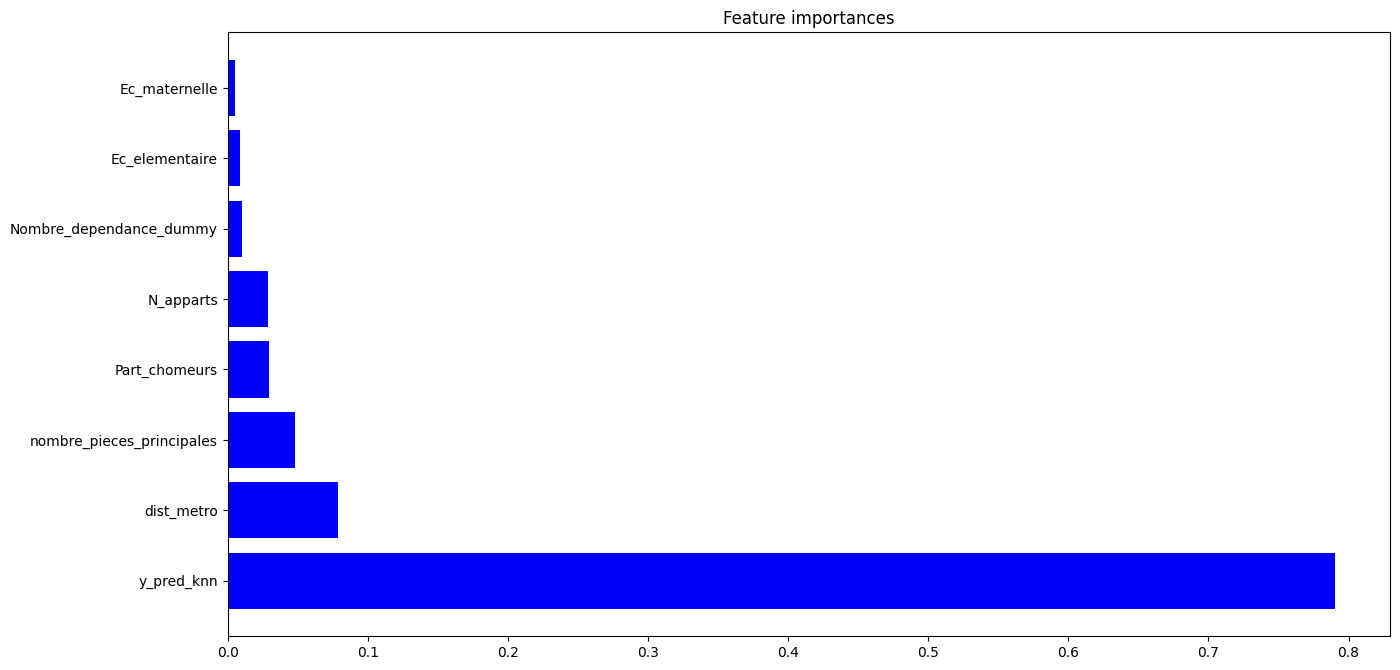

In [95]:
RF_importances = RF_model.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances, X_train_rf)

#### Analysis of mdape

In [96]:
X_test = df_test.copy()
X_test['y_pred_knn'] = knn_pipe.predict(X_test[features_knn])

In [97]:
y_pred = RF_model.predict(X_test[features_RF + ['y_pred_knn']])
X_test["y_pred"] = y_pred
X_test['y_true'] = df_test[label_test]
X_test['mdape'] = np.abs((X_test['y_true'] - X_test["y_pred"])/X_test['y_true'])*100

In [277]:
X_test.groupby('Arrondissement').agg({'mdape' : 'median'}).reset_index().set_index('Arrondissement').T

Arrondissement,69381,69382,69383,69384,69385,69386,69387,69388,69389
mdape,9.842964,10.968654,7.238813,9.728509,8.800586,9.104895,8.122175,8.618564,9.071274


In [278]:
X_test.groupby('quarter').agg({'mdape' : 'median'}).reset_index().set_index('quarter').T

quarter,2021_Q2,2021_Q3,2021_Q4,2022_Q1,2022_Q2
mdape,8.507777,8.388363,9.028803,8.985574,8.848869


In [270]:
fig = px.scatter(X_test, x = 'surface_reelle_bati', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 150])
fig.show()

In [271]:
fig = px.scatter(X_test, x = 'valeur_fonciere', y = 'mdape')
fig.update_layout(yaxis_range=[-0.5, 150])
fig.show()

## Gradient Boost

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('GBoost', GradientBoostingRegressor())])
parameters = {'GBoost__n_estimators': [50, 100, 150]} # defining parameter space
gboost_pipe = GridSearchCV(pipe, parameters, cv=5)
gboost_pipe.fit(X_train_rf, y_train)

compute_scores(gboost_pipe, X_test_rf, y_test)

In [ ]:
gboost_pipe.best_params_

**Features importance**

In [ ]:
model_rf = RandomForestRegressor(max_depth=10)
model_rf.fit(X_train_rf, y_train)

#Prediciton 
y_pred_rf = model_rf.predict(X_test_rf)

importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_rf.columns
# plot
nb_features = X_train_rf.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()

XG BOOST

In [ ]:
df_train.columns

In [ ]:
model_gb = GradientBoostingRegressor(n_estimators = 100)
model_gb.fit(X_train_rf, y_train)

#Prediciton 
y_pred_rf = model_gb.predict(X_test_rf)

importances = model_gb.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train_rf.columns
# plot
nb_features = X_train_rf.shape[1]
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.barh(
    range(nb_features),
    importances[indices],
    color='b')
plt.yticks(range(nb_features), columns[indices], rotation='horizontal', size=10)
plt.show()

## Explainations of the 2 different groups

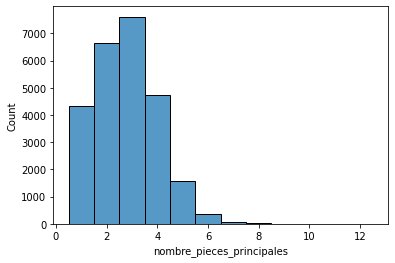

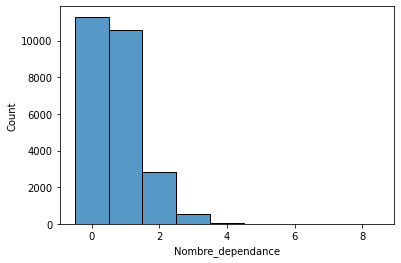

In [18]:
import seaborn as sc
sc.histplot(df['nombre_pieces_principales'], discrete = True)
plt.show()
sc.histplot(df['Nombre_dependance'], discrete = True)
plt.show()

69381


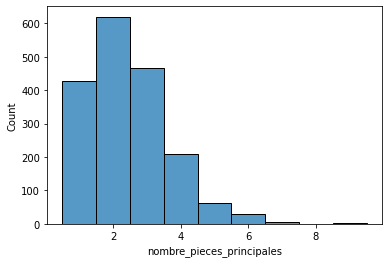

69382


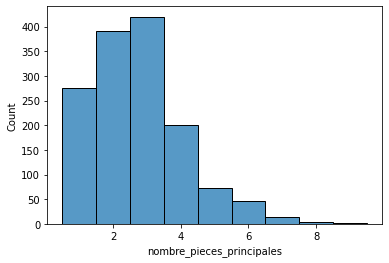

69383


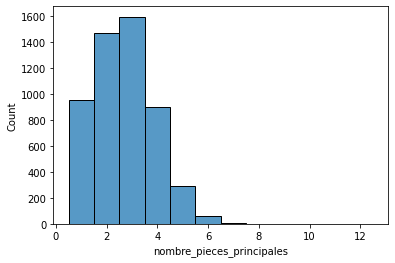

69384


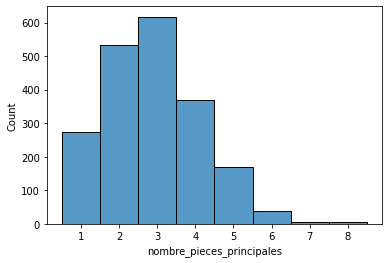

69385


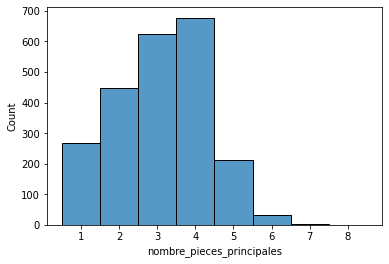

69386


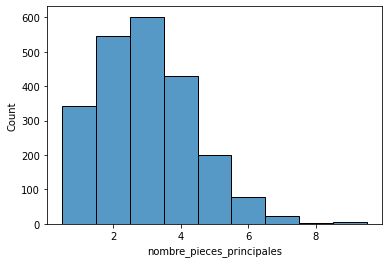

69387


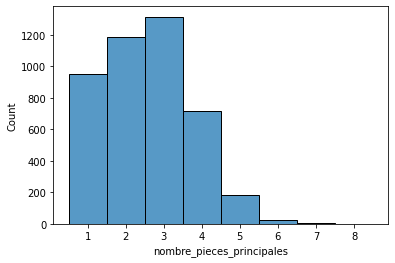

69388


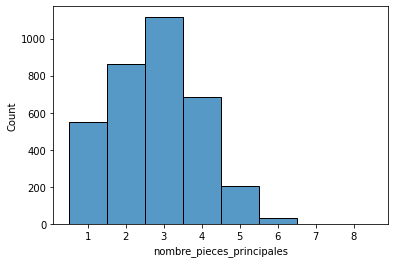

In [16]:
for i in range(1,9) : 
    code = 69380+i
    print(code)
    df_arr = df[df['code_commune'] == code]
    sc.histplot(df_arr['nombre_pieces_principales'], binwidth=1, discrete = True)
    plt.show()

69381


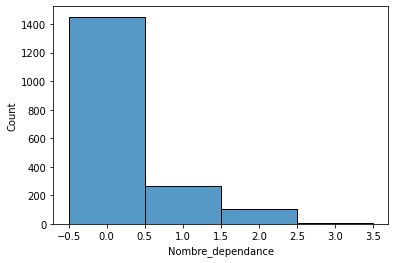

69382


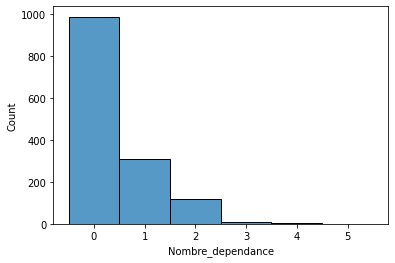

69383


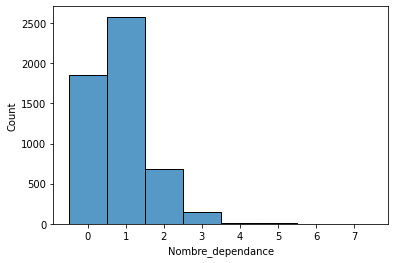

69384


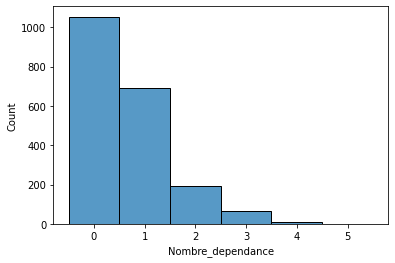

69385


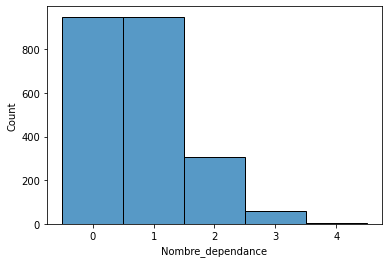

69386


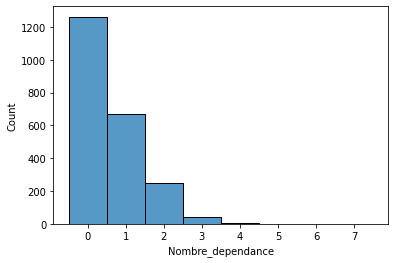

69387


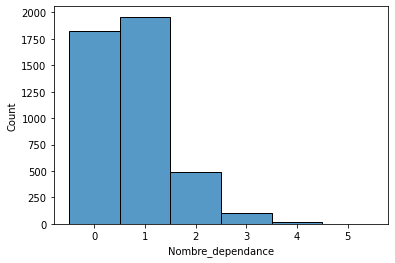

69388


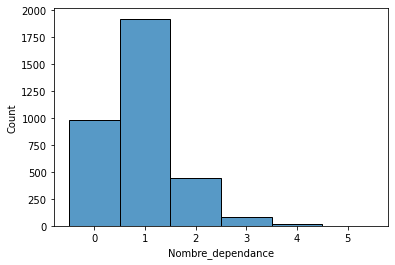

In [17]:
for i in range(1,9) : 
    code = 69380+i
    print(code)
    df_arr = df[df['code_commune'] == code]
    sc.histplot(df_arr['Nombre_dependance'], binwidth=1, discrete = True)
    plt.show()